# Lab 6
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [4]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

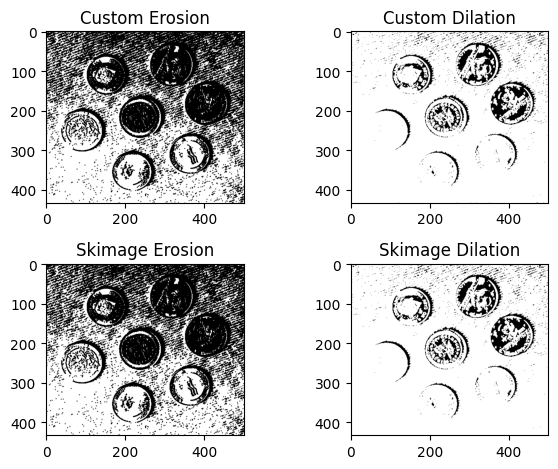

In [24]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''

coins_img = io.imread("img/coins.jpg", as_gray=True)
binary_img = coins_img.copy()

for i in range(len(coins_img)):
    for j in range(len(coins_img[i])):
        binary_img[i][j] = 1 if coins_img[i][j] > .5 else 0 

def fit (img, se, start_i,start_j):
    return min([
        img[i][j] * se[i - start_i][j - start_j] if se[i - start_i][j - start_j] != 0 else 1
        for i in range(start_i, len(se) + start_i) for j in range(start_j, len(se) + start_j) 
    ])


def erosion(img ,se=[[0,1,0], [1,1,1], [0,1,0]]):
    res_img = img.copy()
    leavei = len(se) - 2
    leavej = len(se[0]) - 2
    for i in range(leavei ,len(img) - leavei):
        for j in range (leavej, len(img[i]) - leavej):
            res_img[i][j] = fit(img, se, i - leavei, j - leavej)

    return res_img

def hit (img, se, start_i,start_j):
    return max([
        img[i][j] * se[i - start_i][j - start_j] 
        for i in range(start_i, len(se) + start_i) for j in range(start_j, len(se) + start_j) 
    ])


def dilation(img ,se=[[0,1,0], [1,1,1], [0,1,0]]):
    res_img = img.copy()
    leavei = len(se) - 2
    leavej = len(se[0]) - 2
    for i in range(leavei ,len(img) - leavei):
        for j in range (leavej, len(img[i]) - leavej):
            res_img[i][j] = hit(img, se, i - leavei, j - leavej)

    return res_img

di_img = dilation(binary_img)
er_img = erosion(binary_img)
er_ski_img = binary_erosion(binary_img)
di_ski_img = binary_dilation(binary_img)

plt.subplot(2, 2, 1)
plt.imshow(er_img, cmap='gray')
plt.title("Custom Erosion")

plt.subplot(2, 2, 2)
plt.imshow(di_img, cmap='gray')
plt.title("Custom Dilation")

plt.subplot(2, 2, 3)
plt.imshow(er_ski_img, cmap='gray')
plt.title("Skimage Erosion")

plt.subplot(2, 2, 4)
plt.imshow(di_ski_img, cmap='gray')
plt.title("Skimage Dilation")

plt.tight_layout()
plt.show()




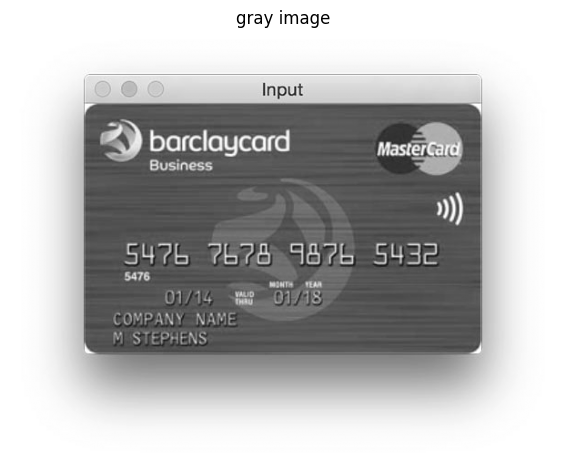

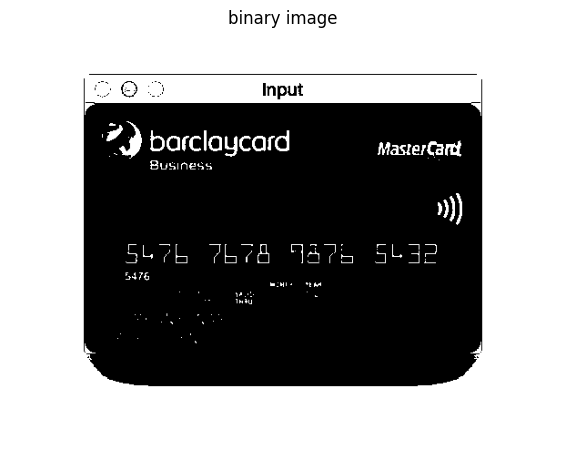

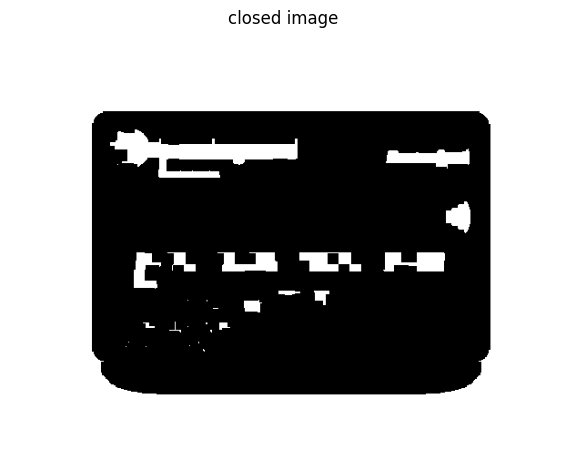

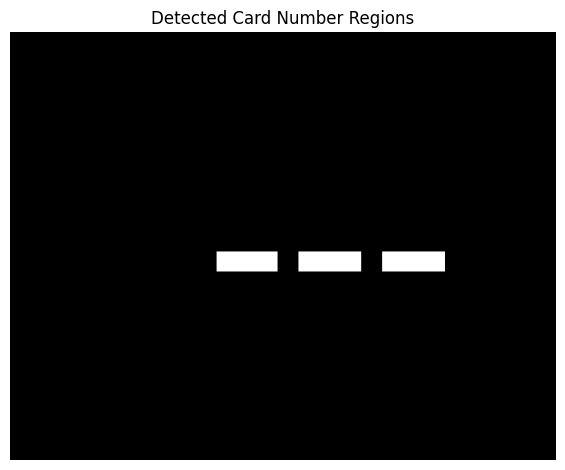

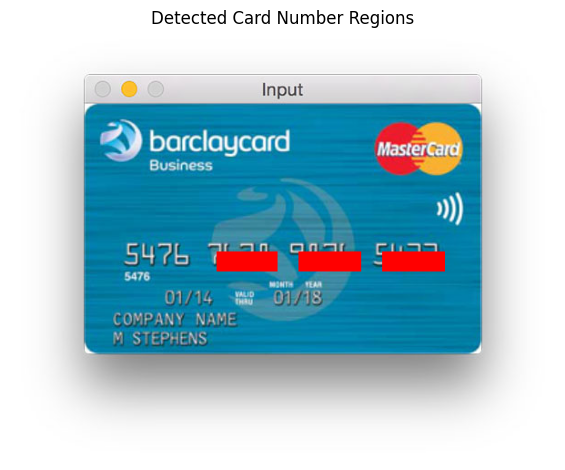

In [39]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''

def show_img(img, text):
    plt.imshow(img, cmap='gray')
    plt.title(text)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

card_img = io.imread("img/card.jpg", as_gray=True)
show_img(card_img, "gray image")

binary_img = card_img.copy()


for i in range(len(card_img)):
    for j in range(len(card_img[i])):
        binary_img[i][j] = 1 if card_img[i][j] > .75 else 0

show_img(binary_img, "binary image")

n = 12
se = [ [ 1 ] * n ] * n

closed_img = erosion(dilation(binary_img, se=se), se= se)
show_img(closed_img, "closed image")

contours = find_contours(closed_img, 0.8)
bounding_boxes = []

for contour in contours:
    y_vals = contour[:, 0]
    x_vals = contour[:, 1]
    ymin, ymax = int(np.min(y_vals)), int(np.max(y_vals))
    xmin, xmax = int(np.min(x_vals)), int(np.max(x_vals))

    width = xmax - xmin
    height = ymax - ymin
    aspect_ratio = width / height if height != 0 else 0

    if 2.5 <= aspect_ratio and aspect_ratio <= 3.5:
        bounding_boxes.append([xmin, xmax, ymin, ymax])
        
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
img_with_boxes = np.zeros(shape=closed_img.shape)

for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img_with_boxes.shape)
    img_with_boxes[rr, cc] = 1 #set color white

show_img(img_with_boxes, "Detected Card Number Regions")
final_img = io.imread("img/card.jpg")

for i, row in enumerate(card_img):
    for j, _ in enumerate(row):
        if img_with_boxes[i][j] == 1:
            final_img[i][j][0] = 255
            final_img[i][j][1] = 0
            final_img[i][j][2] = 0


show_img(final_img, "Detected Card Number Regions")

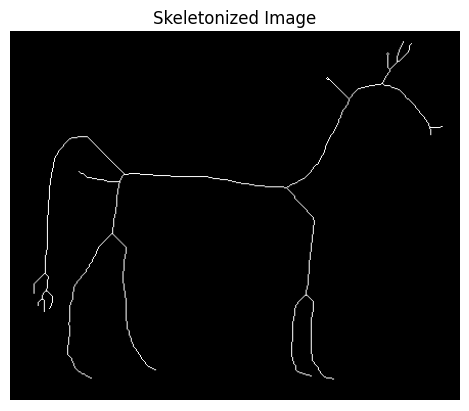

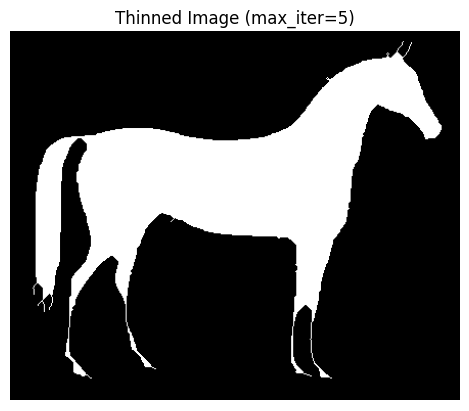

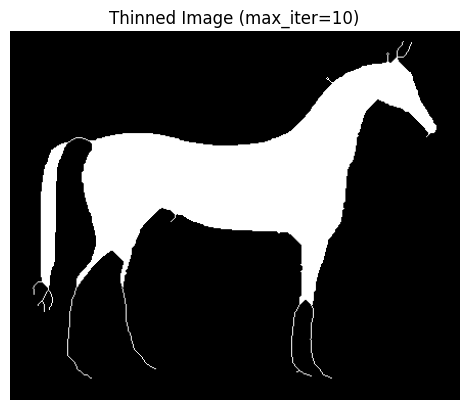

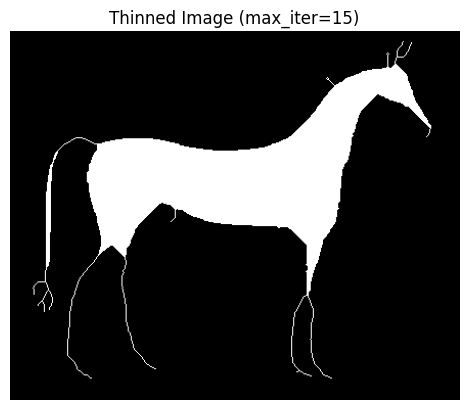

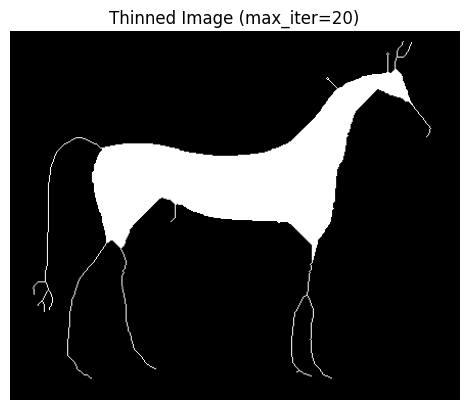

In [51]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''

horse_img = io.imread("img/horse.jpg", as_gray=True)
binary_img = (horse_img > 0.9).astype(np.uint8)

skeleton = skeletonize(binary_img)

plt.imshow(skeleton, cmap='gray')
plt.title("Skeletonized Image")
plt.axis('off')
plt.show()


from skimage.morphology import thin

for max_iter in [5, 10, 15, 20]:
    thinned = thin(binary_img, max_num_iter=max_iter)
    plt.imshow(thinned, cmap='gray')
    plt.title(f"Thinned Image (max_iter={max_iter})")
    plt.axis('off')
    plt.show()